In [1]:
import sys
import os

# Add the parent directory of `notebook/` to sys.path
sys.path.append(os.path.abspath(".."))

# model
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric as tg
import torch_scatter
import e3nn
from e3nn import o3
from typing import Dict, Union

# crystal structure data
from ase import Atom, Atoms
from ase.neighborlist import neighbor_list
from ase.visualize.plot import plot_atoms
palette = ['#43AA8B', '#F8961E', '#F94144']
sub = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")

# data pre-processing and visualization
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
from scipy.interpolate import interp1d
import math

# utilities
import time
from mendeleev import element
from tqdm import tqdm
from utils.utils_data import (load_data, train_valid_test_split, plot_example, plot_predictions, weighted_mean, r2_score, save_or_load_onehot, build_data)
from utils.utils_model_full_tensor import Network, train, evaluate
import e3nn.o3 as o3
from e3nn.util.jit import compile_mode
from e3nn.io import CartesianTensor
from e3nn.o3 import wigner_D, so3_generators
# from utils.dielectric_utils import cart2realsphvec

bar_format = '{l_bar}{bar:10}{r_bar}{bar:-10b}'
default_dtype = torch.float64
torch.set_default_dtype(default_dtype)

# Create a colormap based on the number of unique symbols
datasets = ['g', 'y', 'r']
colors = dict(zip(datasets, palette))
cmap = mpl.colors.LinearSegmentedColormap.from_list('cmap', [palette[k] for k in [0,2,1]])


# Check device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print('torch device:' , device)

## load data
data_file = '../dataset/symmetrized_dataset.pkl'
df, species = load_data(data_file)
df = df.reset_index(drop=True)

print('data acquired')

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Helvetica', 'Arial', 'Liberation Sans', 'sans-serif']

torch device: cuda:0
data acquired


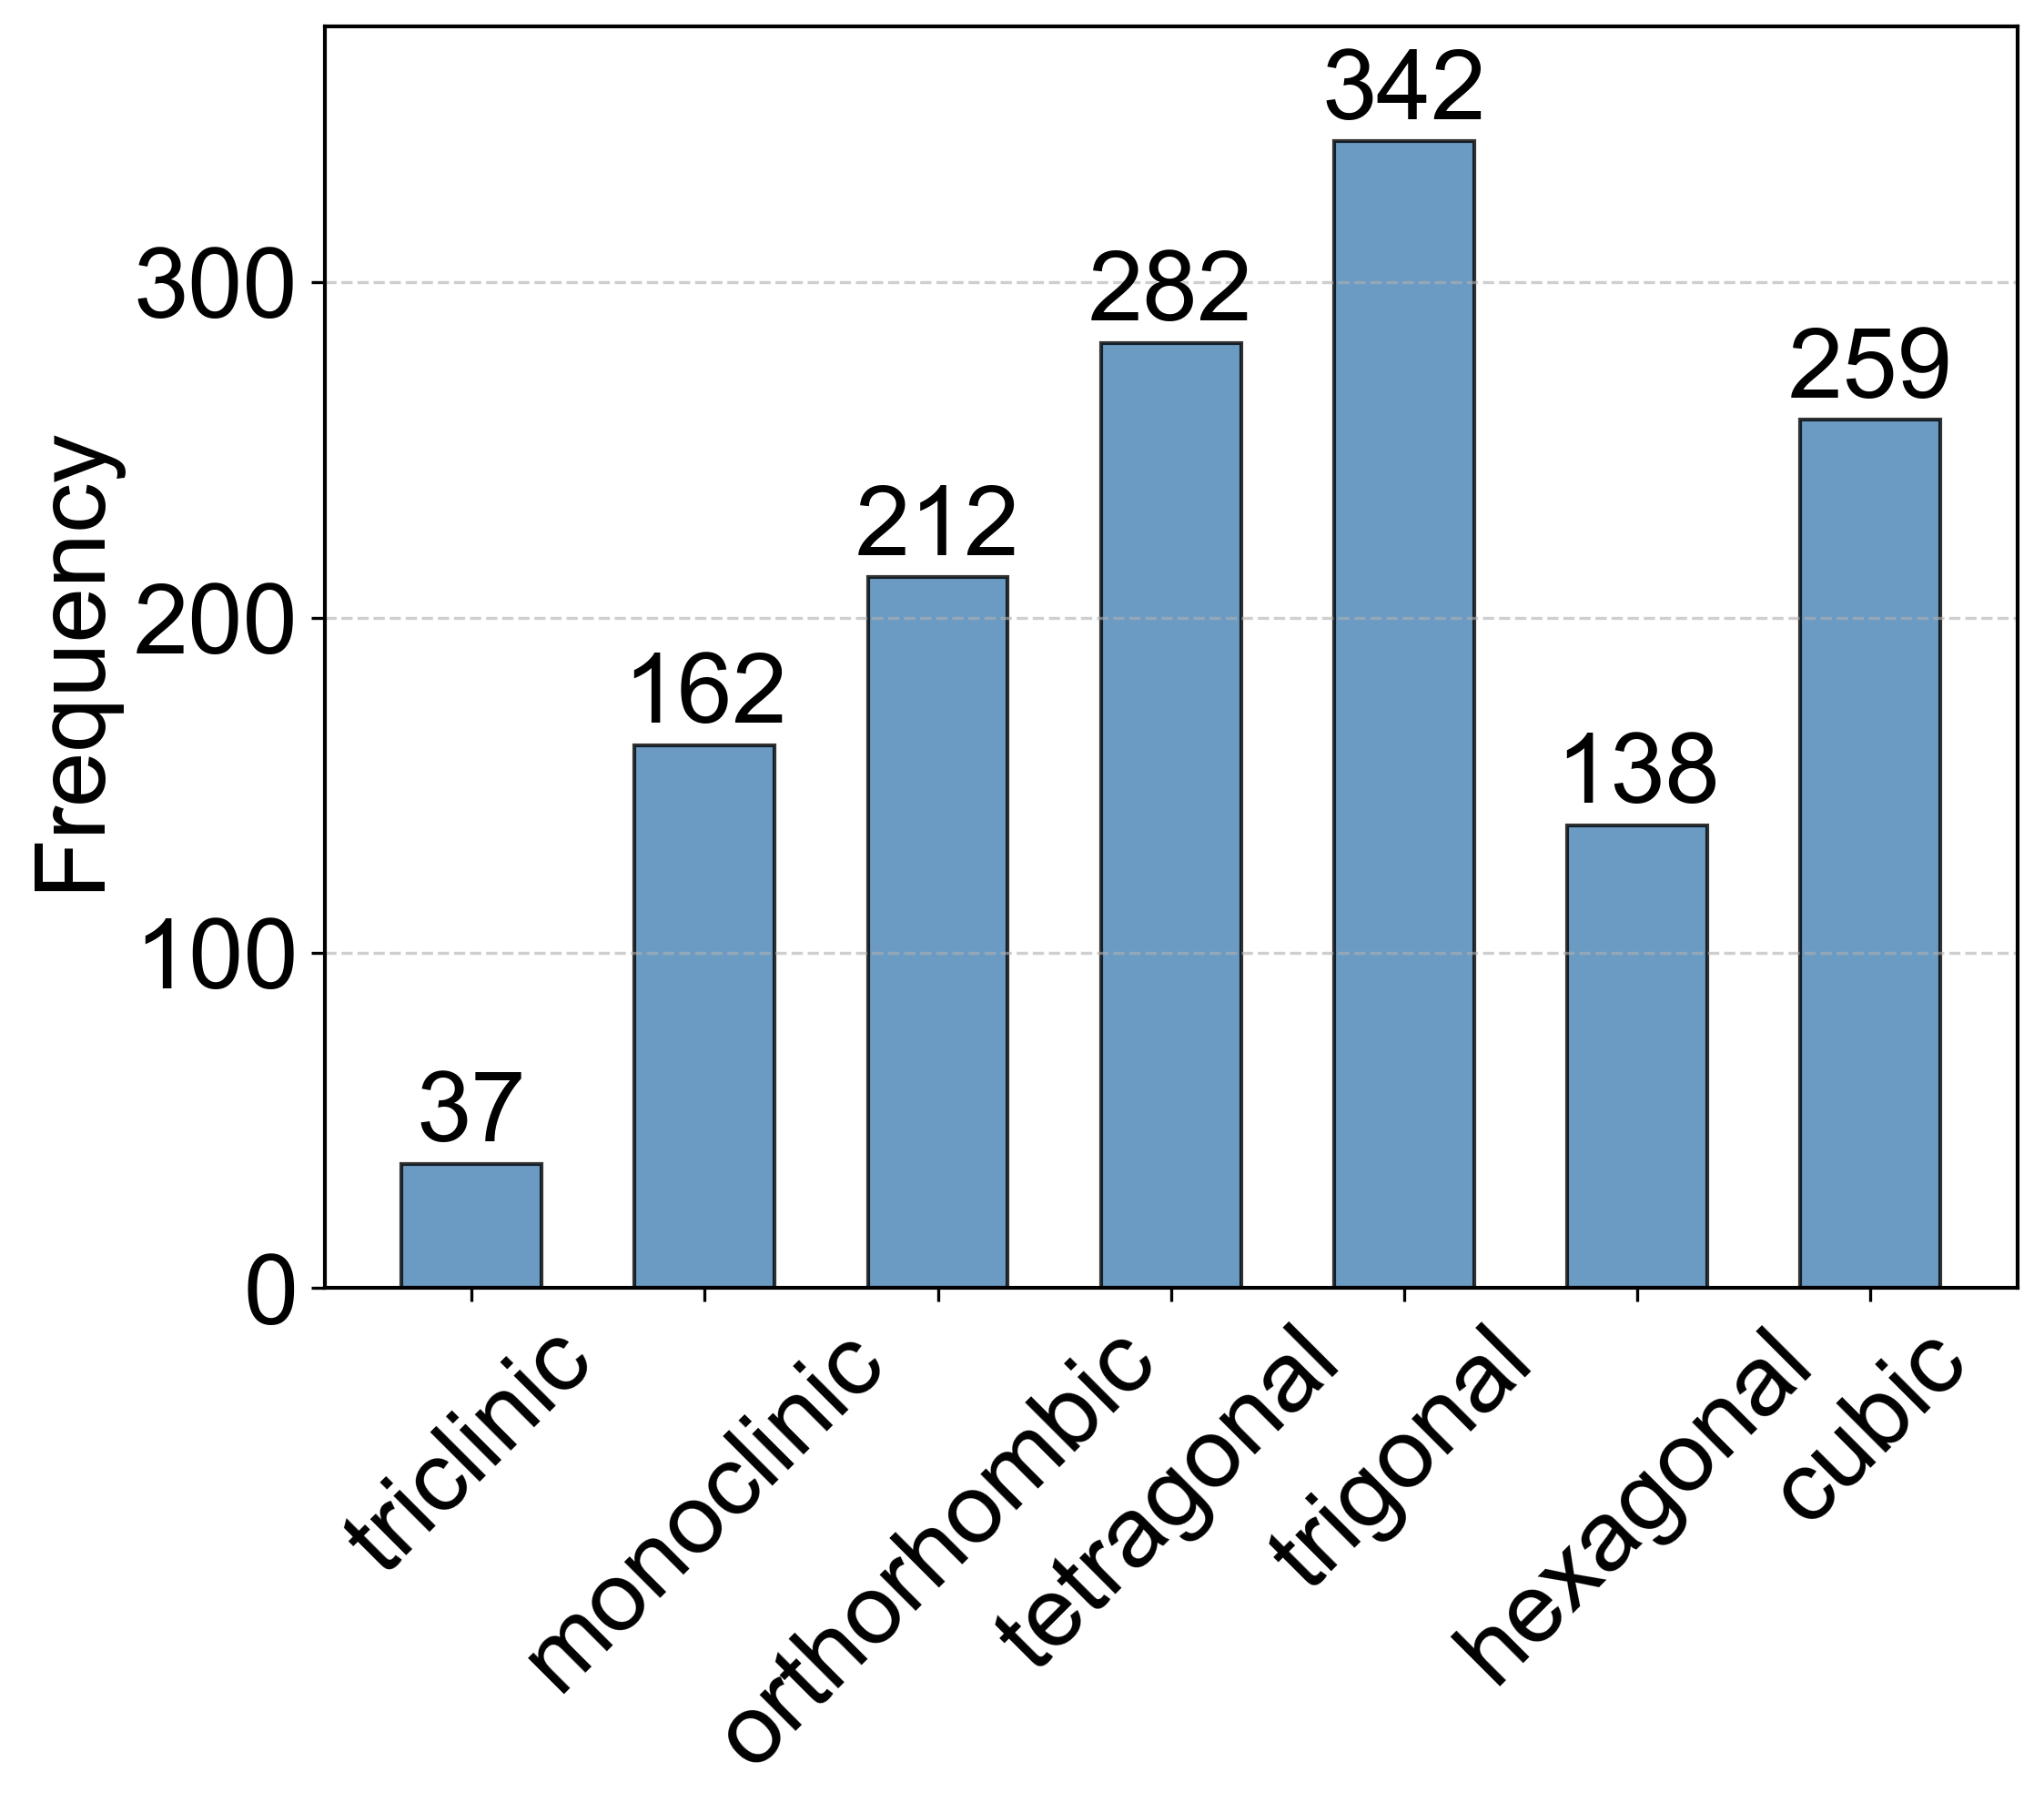

In [2]:
import matplotlib.pyplot as plt
from collections import Counter

# Define crystal system order by space group number
crystal_system_order = [
    "triclinic", "monoclinic", "orthorhombic", 
    "tetragonal", "trigonal", "hexagonal", "cubic"
]

# Count occurrences of each crystal system
crystal_system_counts = Counter(df["crystal_system"])

# Sort by predefined order instead of count
sorted_counts = [(sys, crystal_system_counts.get(sys, 0)) for sys in crystal_system_order]

# Unpack sorted data
systems, counts = zip(*sorted_counts)

# Create figure
plt.figure(figsize=(8, 6),dpi=300)
bars = plt.bar(systems, counts, width=0.6, color="steelblue", edgecolor="black", alpha=0.8)

# Add value labels on top of bars
for bar, count in zip(bars, counts):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + max(counts) * 0.02, 
             str(count), ha='center', fontsize=26, color="black")

# Styling
plt.ylabel("Frequency", fontsize=26)
# plt.xlabel("Crystal System", fontsize=20)
# plt.title("Crystal System Statistics Histogram", fontsize=16)

plt.xticks(fontsize=26, rotation=45)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=26)

# Subtle reference lines
plt.ylim(0, max(counts) * 1.1)
plt.grid(axis="y", linestyle="--", alpha=0.6)  # Add a subtle grid for readability

# Show plot
plt.show()


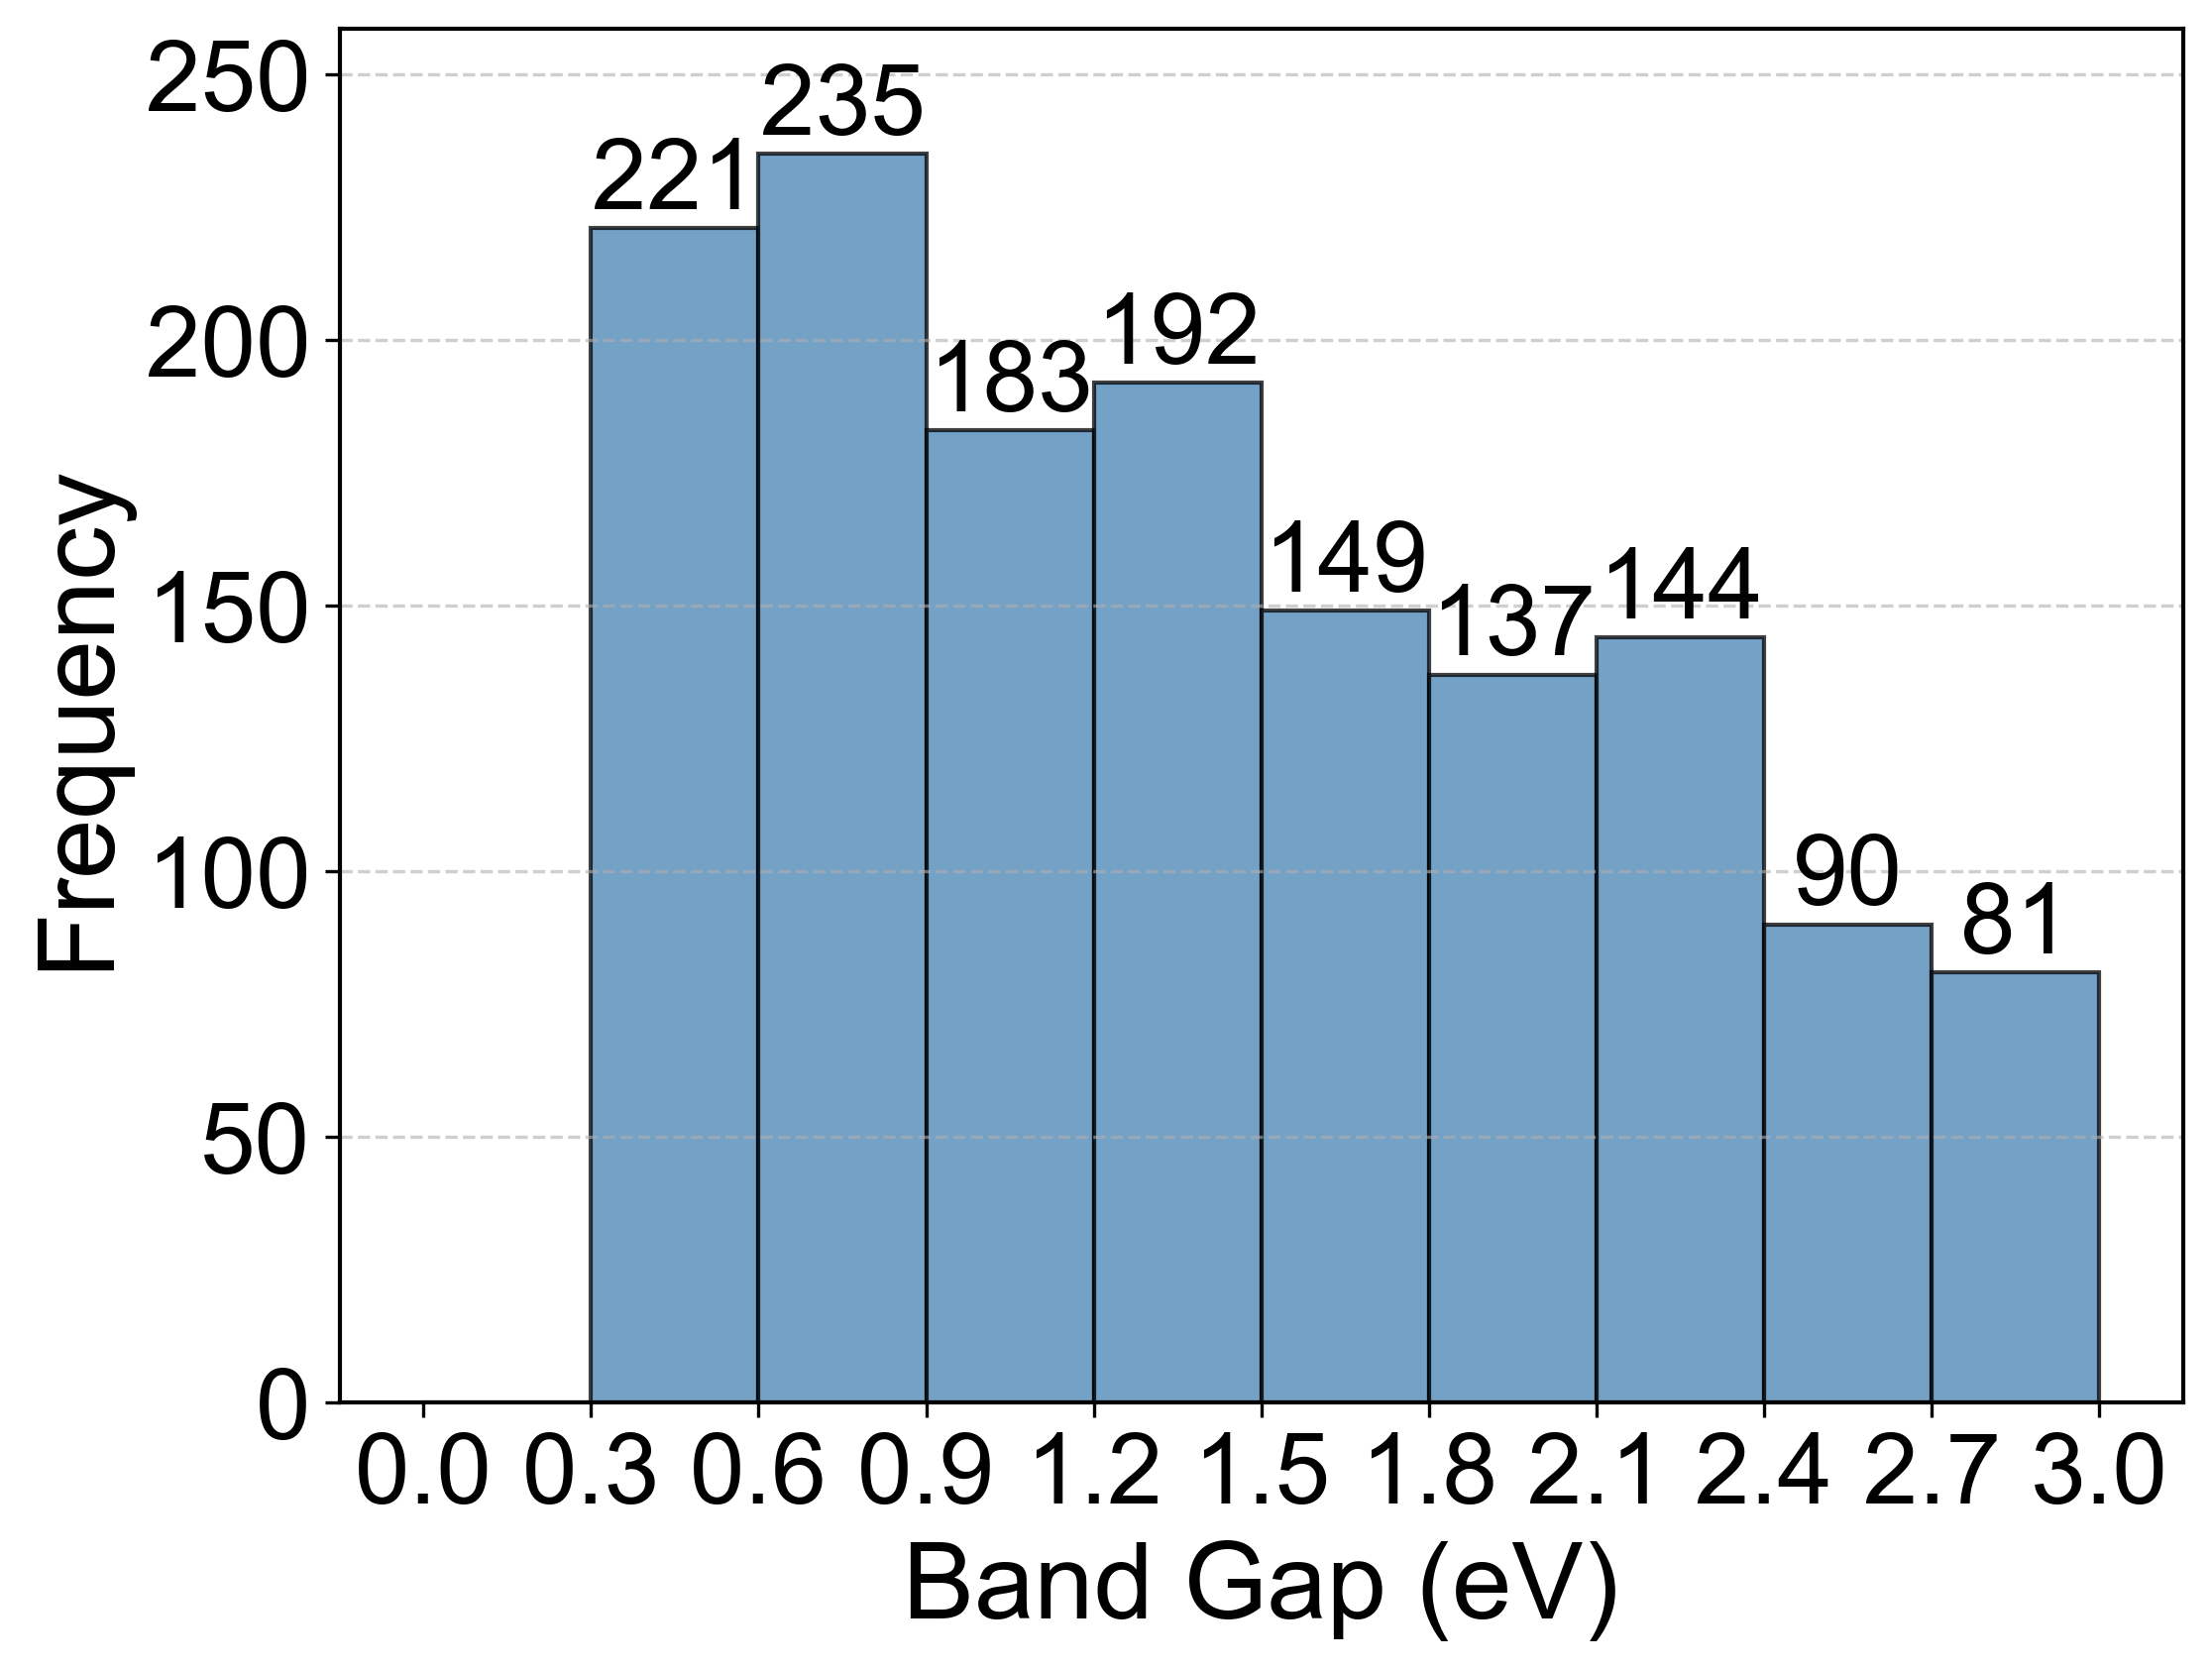

In [3]:
band_gaps = df["bandgap"].dropna()  # Remove any missing values

# Define bin edges for better granularity
bin_width = 0.3
bin_edges = np.arange(0, max(band_gaps) + bin_width, bin_width)

# Create figure
plt.figure(figsize=(8, 6),dpi=300)
hist_values, _, bars = plt.hist(band_gaps, bins=bin_edges, edgecolor="black", alpha=0.75, color="steelblue")

# Add value labels above bars
for bar, count in zip(bars, hist_values):
    if count > 0:
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
                 str(int(count)), ha='center', va='bottom', fontsize=24, color="black")

# Set tick marks dynamically based on data range
# xtick_interval = 0.25 if max(band_gaps) > 2 else 0.1  # Adjust based on max band gap
xtick_interval = 0.3
plt.xticks(np.arange(0, max(band_gaps) + xtick_interval, xtick_interval),fontsize=24)
plt.yticks(fontsize=24)

# Labels and title
plt.xlabel("Band Gap (eV)", fontsize=26)
plt.ylabel("Frequency", fontsize=26)

# Subtle reference line instead of a full grid
plt.ylim(0, max(hist_values) * 1.1)
plt.grid(axis="y", linestyle="--", alpha=0.6)  # Add a subtle grid for readability

# Show plot
plt.show()
